In [ ]:
!pip install transformers datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.2 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.


In [ ]:
import torch, os
import pandas as pd
from transformers import pipeline, BertForSequenceClassification, BertTokenizerFast
from torch.utils.data import Dataset

In [ ]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
ROOT_DIR = "/content/dataTest_Training.csv"

df_org= pd.read_csv(ROOT_DIR)

df_org = df_org.sample(frac=1.0, random_state=42)

df_org.head()

,ID,category,text
1357,2012-02-08_2012-02-08_826,INFORMATION DISCLOSURE,# Item 7.01 Regulation FD Disclosure Deere& ...
2367,2018-01-23_2018-01-23_301,INFORMATION DISCLOSURE,# Item 7.01 Regulation FD Disclosure On Janu...
2822,2012-11-16_2012-11-16_1118,SENIOR PERSONNEL CHANGE,# Item 5.02 Departure of Directors or Certain ...
2126,2011-05-03_2011-05-03_825,INFORMATION DISCLOSURE,# Item 2.02 Results of Operations and Financia...
1544,2016-08-08_2016-08-08_777,FINANCIAL ACTIVITIES,"# Item 8.01 OTHER EVENTS On August 8, 2016, ..."


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
labels = df_org['category'].unique().tolist()
labels = [s.strip() for s in labels ]
labels

['INFORMATION DISCLOSURE',
 'SENIOR PERSONNEL CHANGE',
 'FINANCIAL ACTIVITIES',
 'OPERATION ACTIVITIES',
 'BUSINESS COMBINATION AND RESTRUCTURING',
 'REPURCHASE PROGRAM UPDATE',
 'INTELLECTUAL PROPERTY ACTIVITIES',
 'DOCUMENT UPDATE',
 'LITIGATION AND LAWSUIT',
 'DELISTING, TRADING SUSPENSION']

In [ ]:
for key, value in enumerate(labels):
    print(value)

INFORMATION DISCLOSURE
SENIOR PERSONNEL CHANGE
FINANCIAL ACTIVITIES
OPERATION ACTIVITIES
BUSINESS COMBINATION AND RESTRUCTURING
REPURCHASE PROGRAM UPDATE
INTELLECTUAL PROPERTY ACTIVITIES
DOCUMENT UPDATE
LITIGATION AND LAWSUIT
DELISTING, TRADING SUSPENSION


In [ ]:
for key, value in enumerate(labels):
    print(value)

INFORMATION DISCLOSURE
SENIOR PERSONNEL CHANGE
FINANCIAL ACTIVITIES
OPERATION ACTIVITIES
BUSINESS COMBINATION AND RESTRUCTURING
REPURCHASE PROGRAM UPDATE
INTELLECTUAL PROPERTY ACTIVITIES
DOCUMENT UPDATE
LITIGATION AND LAWSUIT
DELISTING, TRADING SUSPENSION


In [ ]:
NUM_LABELS= len(labels)

id2label={id:label for id,label in enumerate(labels)}

label2id={label:id for id,label in enumerate(labels)}

In [ ]:
id2label, label2id

({0: 'INFORMATION DISCLOSURE',
  1: 'SENIOR PERSONNEL CHANGE',
  2: 'FINANCIAL ACTIVITIES',
  3: 'OPERATION ACTIVITIES',
  4: 'BUSINESS COMBINATION AND RESTRUCTURING',
  5: 'REPURCHASE PROGRAM UPDATE',
  6: 'INTELLECTUAL PROPERTY ACTIVITIES',
  7: 'DOCUMENT UPDATE',
  8: 'LITIGATION AND LAWSUIT',
  9: 'DELISTING, TRADING SUSPENSION'},
 {'INFORMATION DISCLOSURE': 0,
  'SENIOR PERSONNEL CHANGE': 1,
  'FINANCIAL ACTIVITIES': 2,
  'OPERATION ACTIVITIES': 3,
  'BUSINESS COMBINATION AND RESTRUCTURING': 4,
  'REPURCHASE PROGRAM UPDATE': 5,
  'INTELLECTUAL PROPERTY ACTIVITIES': 6,
  'DOCUMENT UPDATE': 7,
  'LITIGATION AND LAWSUIT': 8,
  'DELISTING, TRADING SUSPENSION': 9})

In [ ]:
df_org.head()

,ID,category,text
1357,2012-02-08_2012-02-08_826,INFORMATION DISCLOSURE,# Item 7.01 Regulation FD Disclosure Deere& ...
2367,2018-01-23_2018-01-23_301,INFORMATION DISCLOSURE,# Item 7.01 Regulation FD Disclosure On Janu...
2822,2012-11-16_2012-11-16_1118,SENIOR PERSONNEL CHANGE,# Item 5.02 Departure of Directors or Certain ...
2126,2011-05-03_2011-05-03_825,INFORMATION DISCLOSURE,# Item 2.02 Results of Operations and Financia...
1544,2016-08-08_2016-08-08_777,FINANCIAL ACTIVITIES,"# Item 8.01 OTHER EVENTS On August 8, 2016, ..."


In [ ]:
df_org["labels"]=df_org.category.map(lambda x: label2id[x.strip()])

In [ ]:
df_org.head()

,ID,category,text,labels
1357,2012-02-08_2012-02-08_826,INFORMATION DISCLOSURE,# Item 7.01 Regulation FD Disclosure Deere& ...,0
2367,2018-01-23_2018-01-23_301,INFORMATION DISCLOSURE,# Item 7.01 Regulation FD Disclosure On Janu...,0
2822,2012-11-16_2012-11-16_1118,SENIOR PERSONNEL CHANGE,# Item 5.02 Departure of Directors or Certain ...,1
2126,2011-05-03_2011-05-03_825,INFORMATION DISCLOSURE,# Item 2.02 Results of Operations and Financia...,0
1544,2016-08-08_2016-08-08_777,FINANCIAL ACTIVITIES,"# Item 8.01 OTHER EVENTS On August 8, 2016, ...",2


<Axes: ylabel='count'>

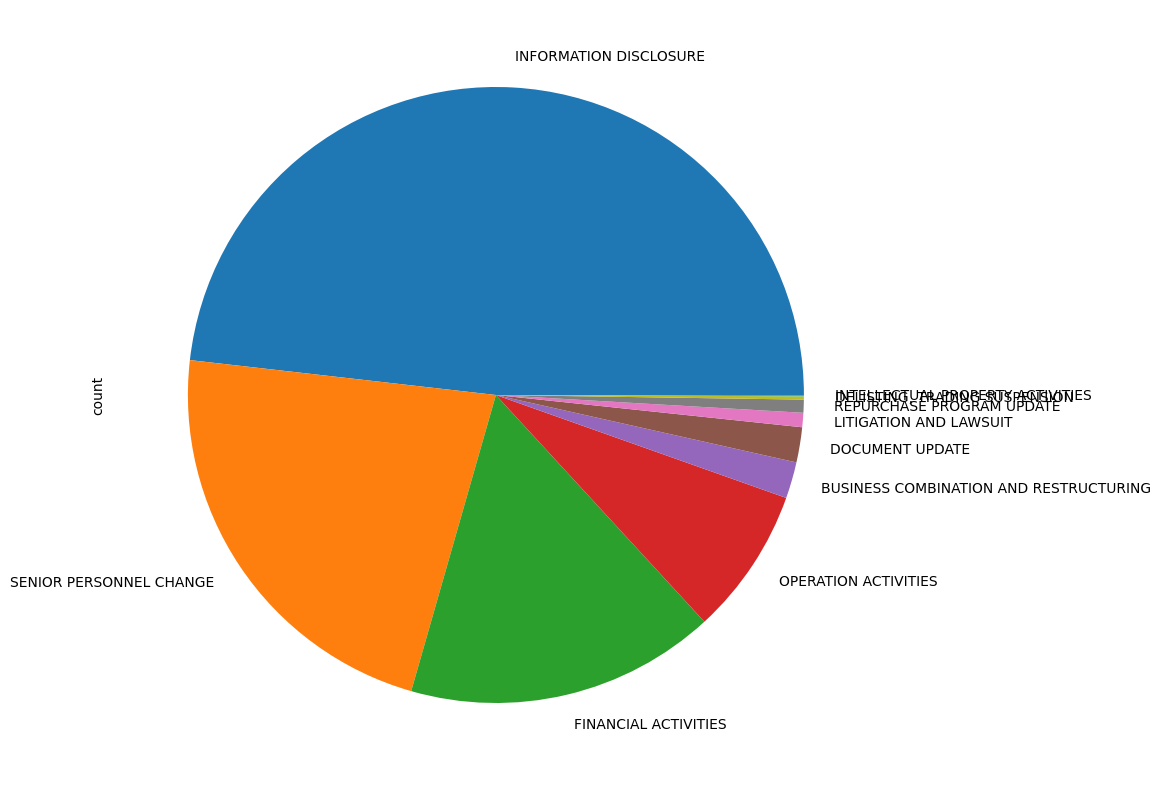

In [ ]:
df_org.category.value_counts().plot(kind='pie', figsize=(10,10))

In [ ]:
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=NUM_LABELS, id2label=id2label, label2id=label2id)
model.to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
SIZE= df_org.shape[0]

train_texts= list(df_org.text[:SIZE//2])

val_texts=   list(df_org.text[SIZE//2:(3*SIZE)//4 ])

test_texts=  list(df_org.text[(3*SIZE)//4:])

train_labels= list(df_org.labels[:SIZE//2])

val_labels=   list(df_org.labels[SIZE//2:(3*SIZE)//4])

test_labels=  list(df_org.labels[(3*SIZE)//4:])

In [ ]:
len(train_texts)

1466

In [ ]:
len(train_texts), len(val_texts), len(test_texts)

(1466, 733, 733)

In [ ]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings  = tokenizer(val_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

In [ ]:
class DataLoader(Dataset):
    def __init__(self, encodings, labels):
        self.encodings= encodings
        self.labels= labels
    def __getitem__(self,idx):
        item= {key:torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels']=torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.labels)

In [ ]:
train_dataloader = DataLoader(train_encodings,train_labels)
val_dataloader = DataLoader(val_encodings, val_labels)
test_dataloader = DataLoader(test_encodings, test_labels)

In [ ]:
from transformers import TrainingArguments, Trainer

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support


def compute_metrics(pred):
   labels = pred.label_ids
   preds =  pred.predictions.argmax(-1)
   precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average = 'macro')
   acc= accuracy_score(labels, preds)

   return{
      'Acurracy':acc,
      'F1' : f1,
      'Precision': precision,
      'Recall': recall

   }

In [ ]:
training_args= TrainingArguments(
    output_dir='./Bert_finetuned_Test',
    do_train= True,
    do_eval=True,
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size= 32,
    warmup_steps=100,
    weight_decay= 0.01,
    logging_strategy= 'steps',
    logging_dir= './multi-calss-logs',
    logging_steps=50,
    evaluation_strategy= "steps",
    eval_steps=50,
    save_strategy="steps",
    fp16= True,
    load_best_model_at_end= True

)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataloader,
    eval_dataset=val_dataloader,
    compute_metrics= compute_metrics
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:488: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


In [ ]:
trainer.train()

Step,Training Loss,Validation Loss,Acurracy,F1,Precision,Recall
50,1.902100,1.195997,0.645293,0.234229,0.298499,0.223346
100,0.827400,0.594218,0.840382,0.323835,0.319133,0.330186
150,0.527500,0.561240,0.849932,0.358173,0.423849,0.361607
200,0.469100,0.559666,0.854025,0.334506,0.328169,0.341250
250,0.370600,0.465791,0.874488,0.394747,0.389201,0.404462


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

TrainOutput(global_step=276, training_loss=0.7683729762616365, metrics={'train_runtime': 150.7688, 'train_samples_per_second': 29.17, 'train_steps_per_second': 1.831, 'total_flos': 1157245539028992.0, 'train_loss': 0.7683729762616365, 'epoch': 3.0})

In [ ]:
q=[trainer.evaluate(eval_dataset=df_org) for df_org in [train_dataloader, val_dataloader, test_dataloader]]

pd.DataFrame(q, index=["train","val","test"]).iloc[:,:5]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,eval_loss,eval_Acurracy,eval_F1,eval_Precision,eval_Recall
train,0.240793,0.924966,0.439023,0.427324,0.456806
val,0.463425,0.866303,0.386136,0.386481,0.394438
test,0.391839,0.888131,0.488357,0.554213,0.505368


In [ ]:
from transformers import DistilBertForSequenceClassification, DistilBertTokenizerFast

In [ ]:
def predict(text):

    inputs = tokenizer(text, padding=True, truncation=True,  return_tensors="pt").to("cuda")
    outputs = model(**inputs)
    probs = outputs[0].softmax(1)
    pred_label_idx = probs.argmax()
    pred_label = model.config.id2label[pred_label_idx.item()]

    return probs, pred_label_idx, pred_label


In [ ]:
text = "Item 2.02 Results of Operations and Financial Condition On April 24, 2012, Waters Corporation announced its results of operations for the quarter ended March 31, 2012. A copy of the related press release is attached hereto as Exhibit 99.1 to this Form 8-K and is incorporated herein by reference in its entirety. 9.01 Financial Statements and Exhibits"
predict(text)

(tensor([[9.8918e-01, 1.0955e-03, 3.6184e-03, 1.2758e-03, 7.6890e-04, 1.1693e-03,
          5.3547e-04, 8.1849e-04, 1.0494e-03, 4.8994e-04]], device='cuda:0',
        grad_fn=<SoftmaxBackward0>),
 tensor(0, device='cuda:0'),
 'INFORMATION DISCLOSURE')

In [ ]:
model_path = "TEST"
trainer.save_model(model_path)
tokenizer.save_pretrained(model_path)

('TEST/tokenizer_config.json',
 'TEST/special_tokens_map.json',
 'TEST/vocab.txt',
 'TEST/added_tokens.json',
 'TEST/tokenizer.json')

In [ ]:
#reload the model for inference
model_path = "TEST"
model = BertForSequenceClassification.from_pretrained(model_path)
tokenizer = BertTokenizerFast.from_pretrained(model_path)
nlp = pipeline("text-classification", model=model, tokenizer=tokenizer, function_to_apply= 'none', max_length=512, truncation= True, return_all_scores=True)

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [ ]:
def predict_with_none_category(text):
    all_scores = nlp(text)

    # Adjust categories to "NONE" if the score is negative (or some condition you specify)
    adjusted_results = []
    for score_dict in all_scores[0]:
        if score_dict['score'] < 0:  # Adjust this condition based on your scoring specifics
            adjusted_results.append({'label': 'NONE', 'score': score_dict['score']})
        else:
            adjusted_results.append(score_dict)

    # Sort and get the top 3
    top_3 = sorted(adjusted_results, key=lambda x: x['score'], reverse=True)[:3]

    return top_3

# Example usage
text = "# Item 8.01 Other Events   On February 16, 2021, International Paper Company (the Company) entered into a Consent and Waiver Agreement (the Consent Agreement) with Graphic Packaging Holding Company (GPK), GPI Holding III, LLC (GPI), and Graphic Packaging International Partners, LLC (GPIP) pursuant to which GPIP agreed to repurchase from the Company common units (Units) of GPIP for an aggregate price of approximately $150 million. In addition, under the Consent Agreement, and pursuant to the terms of the Exchange Agreement, dated January 1, 2018, by and among the Company, GPK, GPI and GPIP (the Exchange Agreement) the Company will exchange 15,307,000 Units, or approximately 32% of the aggregate Units owned by the Company. Pursuant to the Exchange Agreement, GPIP will deliver 15,307,000 shares of GPK common stock for the equivalent number of Units, which the Company will sell immediately upon entering into the Consent Agreement. Both the repurchase and exchange are expected to close on February 19, 2021. Following the transactions described above, the Company will own Units representing an ownership interest of approximately 7%.   ---  # Item 9.01 Financial Statements and Exhibits   (d) Exhibits   | Exhibit No. | | Description | | 101 | | Cover Page Interactive Data File - the cover page XBRL tags are embedded within the Inline XBRL document. | | 104 | | The cover page from this Current Report on Form 8-K, formatted as Inline XBRL. |"
top_3_predictions = predict_with_none_category(text)

print("Top 3 predictions:", top_3_predictions)

Top 3 predictions: [{'label': 'BUSINESS COMBINATION AND RESTRUCTURING', 'score': 1.5885640382766724}, {'label': 'INFORMATION DISCLOSURE', 'score': 0.5926961898803711}, {'label': 'FINANCIAL ACTIVITIES', 'score': 0.3170124292373657}]


In [ ]:
#nlp("# Item 8.01 Other Events   On March 7, 2012, Kimberly-Clark Corporation announced that Tony Palmer has been elected as President, Global Brands and Innovation. Mr. Palmers former position was Senior Vice President and Chief Marketing Officer. A copy of the news release announcing the election is attached as Exhibit 99.1 hereto.   ---  # Item 9.01 Financial Statements and Exhibits   (d) Exhibits99.1 News release issued by Kimberly-Clark Corporation on March 7, 2012.   EXHIBIT INDEX")

In [ ]:
# Function to truncate text to a maximum length
def truncate_text(text, max_length):
  tokens = tokenizer.encode(text, truncation=True, max_length=max_length)
  return tokenizer.decode(tokens)

In [ ]:
dataTest= pd.read_csv("/content/extracted_data1.csv")
dataTest.head()

,CIK,ID,Report Date,Item Numbers,Company,Filling date F,Published date F,Counter
0,1000180,2016-05-12_2016-05-12_1064,2016-05-12,# Item 1.01 Entry into a Material Definitive A...,NaN,2016-05-12,2016-05-12,1064
1,1000180,2016-05-10_2016-05-10_986,2016-05-10,"# Item 8.01 Other Events. On May 10, 2016, S...",NaN,2016-05-10,2016-05-10,986
2,1000180,2014-06-16_2014-06-16_1794,2014-06-16,# Item 1.01 Entry Into a Material Definitive A...,NaN,2014-06-16,2014-06-16,1794
3,1000180,2012-10-24_2012-10-24_442,2012-10-23,# Item 5.02 Departure of Directors or Certain ...,NaN,2012-10-24,2012-10-24,442
4,1000180,2012-09-17_2012-09-17_1453,2012-09-13,# Item 5.02 Departure of Directors or Principa...,NaN,2012-09-17,2012-09-17,1453


In [ ]:
dataTest['categories'] = dataTest['Item Numbers'].apply(lambda text: predict_with_none_category(truncate_text(text, 512)))

In [ ]:
dataTest.head()

,CIK,ID,Report Date,Item Numbers,Company,Filling date F,Published date F,Counter,categories
0,1000180,2016-05-12_2016-05-12_1064,2016-05-12,# Item 1.01 Entry into a Material Definitive A...,NaN,2016-05-12,2016-05-12,1064,"[{'label': 'FINANCIAL ACTIVITIES', 'score': 5...."
1,1000180,2016-05-10_2016-05-10_986,2016-05-10,"# Item 8.01 Other Events. On May 10, 2016, S...",NaN,2016-05-10,2016-05-10,986,"[{'label': 'INFORMATION DISCLOSURE', 'score': ..."
2,1000180,2014-06-16_2014-06-16_1794,2014-06-16,# Item 1.01 Entry Into a Material Definitive A...,NaN,2014-06-16,2014-06-16,1794,[{'label': 'BUSINESS COMBINATION AND RESTRUCTU...
3,1000180,2012-10-24_2012-10-24_442,2012-10-23,# Item 5.02 Departure of Directors or Certain ...,NaN,2012-10-24,2012-10-24,442,"[{'label': 'SENIOR PERSONNEL CHANGE', 'score':..."
4,1000180,2012-09-17_2012-09-17_1453,2012-09-13,# Item 5.02 Departure of Directors or Principa...,NaN,2012-09-17,2012-09-17,1453,"[{'label': 'SENIOR PERSONNEL CHANGE', 'score':..."


In [ ]:
dataTest['category']= dataTest['categories'].str.get('label')
dataTest.head()

In [ ]:
dataTest.to_csv("dataTest.csv")
